In [1]:
import scprep, torch, magic, scanpy, sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn, optim
from sklearn import decomposition
from collections import Counter

### Global Setup

In [2]:
np.random.seed(0)
tissue_id = 0
N_ARCHETYPES = 7
azim = -150
tissues = ['WT', 'HFD', 'OB/OB']
usamples = ["WT", "OB/OB", "WT", "HFD"]
lut = {usamples[i]: plt.get_cmap("tab10")(i) for i in range(4)}

In [3]:
adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')

In [4]:
adata_beta_wt = adata_beta[adata_beta.obs['samples'] == tissues[tissue_id]]

In [5]:
wt_magic_op = magic.MAGIC(random_state=42, t=10)
wt_magic = wt_magic_op.fit_transform(adata_beta_wt.to_df())

Calculating MAGIC...
  Running MAGIC on 5847 cells and 16483 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 0.72 seconds.
  Calculated graph and diffusion operator in 0.87 seconds.
Calculated MAGIC in 1.15 seconds.



KeyboardInterrupt



In [ ]:
wt_pc_op = decomposition.PCA(n_components=20, random_state=42)
wt_magic_pc = wt_pc_op.fit_transform(wt_magic)
wt_magic_pc_norm = wt_magic_pc / np.std(wt_magic_pc[:, 0])

### Get extrema

In [36]:
# Density subsampling
distances, _ = sklearn.neighbors.NearestNeighbors(n_neighbors=2000).fit(wt_magic_pc_norm).kneighbors()
distances = distances.max(axis=1)
p = distances / distances.sum()
X_subsample = scprep.select.select_rows(wt_magic_pc_norm, idx=np.random.choice(wt_magic_pc_norm.shape[0],
                                                                int(wt_magic_pc_norm.shape[0]/2), p=p, replace=False))

extrema = torch.Tensor(utils.get_laplacian_extrema(X_subsample, n_extrema=N_ARCHETYPES, subsample=False))
extrema = torch.Tensor(X_subsample[extrema.numpy().astype(int)])

<class 'networkx.utils.decorators.argmap'> compilation 17:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Axes3DSubplot:title={'center':'WT'}>

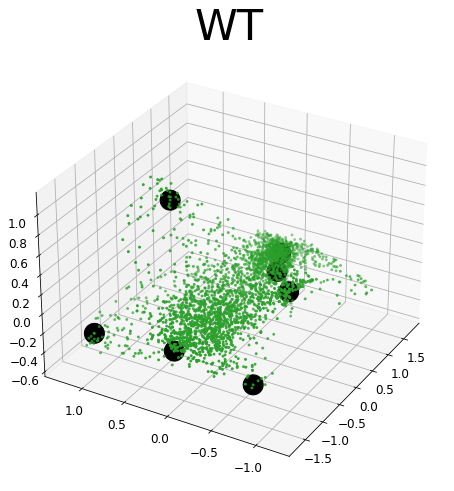

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

scprep.plot.scatter3d(X_subsample, c=lut[tissues[tissue_id]],
                          ylabel=None, zorder=1,
                          title=f'{tissues[tissue_id]}', fontsize=25, colorbar=False, ax=ax)

scprep.plot.scatter3d(extrema.cpu().detach().numpy(), ax=ax, azim=azim,
                             c='black', s=400, figsize=(10,10), colorbar=False, alpha=1)

### Run AAnet

In [50]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=wt_magic_pc_norm.shape[1],
                             device=device, diffusion_extrema=extrema)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [51]:
data_loader = torch.utils.data.DataLoader(wt_magic_pc_norm, batch_size=256, shuffle=True, num_workers=4)

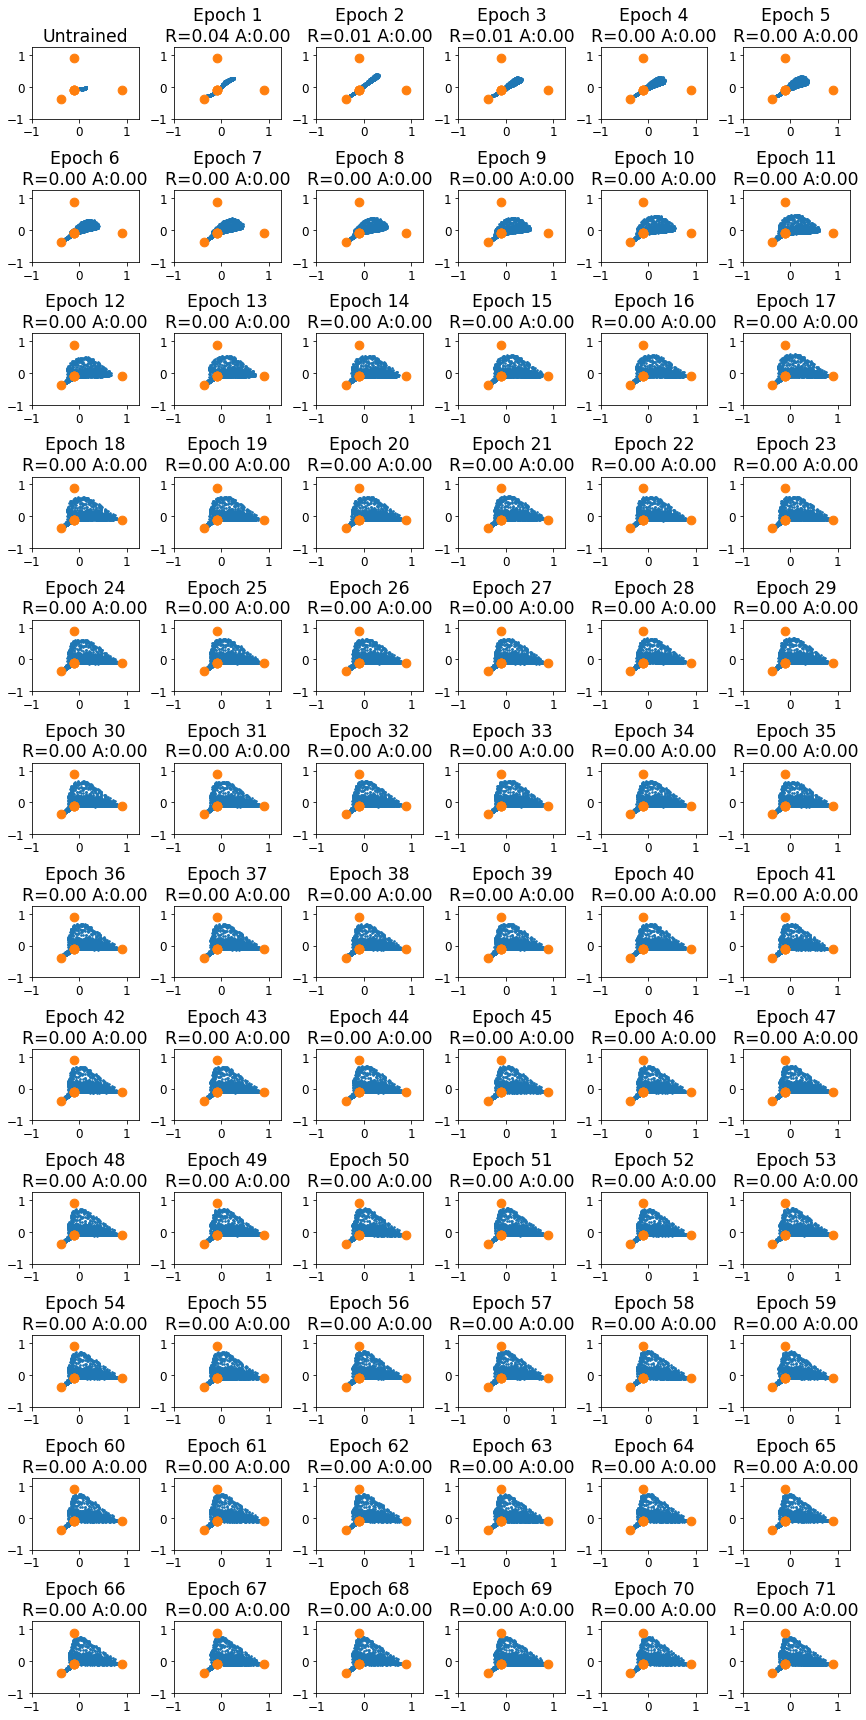

In [52]:
n_row = 12
n_col = 6
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        r_loss = a_loss = 0

        title='Untrained'
    else:
        # gamma_extrema parameter weights how informative graph-based extrema are to model
        loss, r_loss, a_loss=utils.train_epoch(model, data_loader, optimizer, epoch=i)
        title='Epoch {}\nR={:.2f} A:{:.2f}'.format(i, r_loss, a_loss)

    archetypal_embedding = model.encode(torch.Tensor(wt_magic_pc_norm))

    scprep.plot.scatter2d(archetypal_embedding.detach().cpu().numpy(), title=title, ax=ax)
    scprep.plot.scatter2d(model.get_n_simplex(model.n_archetypes).cpu().numpy(), ax=ax)
    ax.set_xlim(-1, 1.25)
    ax.set_ylim(-1, 1.25)

fig.tight_layout()

In [53]:
archetypal_embedding = model.encode(torch.Tensor(wt_magic_pc_norm))
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()
pc_ats = model.decode(model.get_n_simplex(model.n_archetypes).type(torch.float)).cpu().detach().numpy()

In [54]:
data_ats = ((pc_ats * np.std(wt_magic_pc[:,0])) @ wt_pc_op.components_)

## Visualize ATs

In [6]:
wt_magic_pc_norm = pd.read_pickle('results/WT_magic_pc_norm.pkl')
pc_ats = np.load(f'results/{tissues[tissue_id]}_pc_{N_ARCHETYPES}_ats.npy')

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(


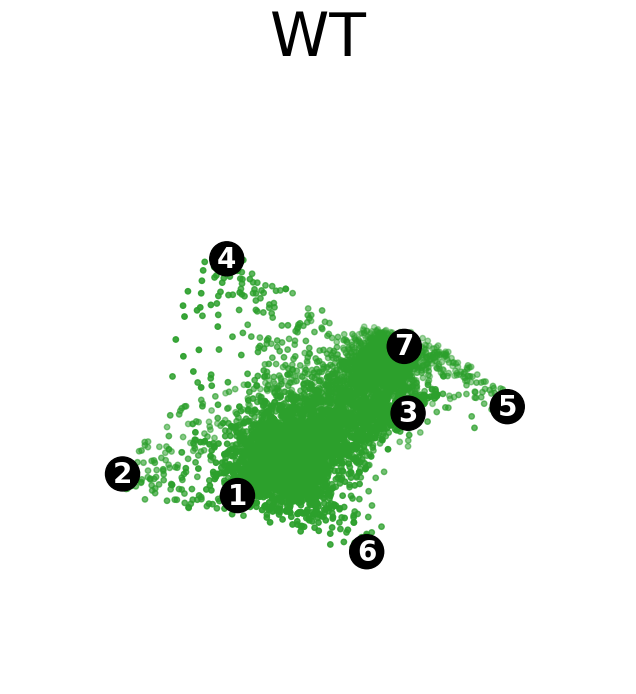

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

scprep.plot.scatter3d(wt_magic_pc_norm, c=lut[tissues[tissue_id]],
                          ylabel=None, zorder=1, ticks=None, s=15,
                          title=f'{tissues[tissue_id]}', fontsize=25, colorbar=False, ax=ax, label='')

scprep.plot.scatter3d(pc_ats, ax=ax, c='black', s=600, figsize=(10,10), colorbar=False, alpha=1,  azim=azim, label='')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.axis('off')
for t,coord in enumerate(pc_ats):
        ax.text(coord[0], coord[1], coord[2], s=t+1, horizontalalignment='center',
                        verticalalignment='center', fontdict={'color': 'white','size':20,'weight':'bold'}, zorder=4)

In [11]:
fig.savefig(f'figures/{tissues[tissue_id]}_{N_ARCHETYPES}_ats.png', dpi=200)

### Save Model

In [58]:
torch.save(model.state_dict(), f'results/{tissues[tissue_id]}_{N_ARCHETYPES}_model_state_dict')

In [59]:
np.save(f'results/{tissues[tissue_id]}_data_{N_ARCHETYPES}_ats', data_ats)
np.save(f'results/{tissues[tissue_id]}_pc_{N_ARCHETYPES}_ats', pc_ats)
np.save(f'results/{tissues[tissue_id]}_latent_coords_{N_ARCHETYPES}_ats', barycentric_archetypal_embedding)